In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os

# 1. Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "F:/Class/FYP/newdataset/train"
val_dir = "F:/Class/FYP/newdataset/validation"
batch_size = 32
finetune_epochs = 10
checkpoint_path = "efficientnet_b3_transfer_learning.pth"

# 2. Dataset Preparation
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        self.transform = transforms.Compose([
            transforms.Resize((300, 300)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(image), torch.tensor(self.labels[idx])

# 3. Transfer Learning Model Definition - Same architecture
class EfficientNetTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained EfficientNet-B3
        self.efficientnet = models.efficientnet_b3(weights="IMAGENET1K_V1")
        
        # Replace classifier layer
        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# 4. Initialize Components
train_dataset = ImageDataset(train_dir)
val_dataset = ImageDataset(val_dir)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 5. Load the previously trained model
model = EfficientNetTransferLearning(num_classes=len(train_dataset.classes)).to(device)

# Load the saved checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint.get('epoch', 'unknown')} with validation accuracy: {checkpoint.get('val_accuracy', 'unknown')}%")

# 6. Unfreeze specific layers for fine-tuning
for name, param in model.named_parameters():
    # Freeze all parameters first
    param.requires_grad = False
    
    # Then unfreeze only the last 2 convolutional blocks and classifier
    if "features.5" in name or "features.6" in name or "classifier" in name:
        param.requires_grad = True

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} out of {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

# 7. Use smaller learning rate for fine-tuning
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# 8. Fine-tuning Loop
best_accuracy = checkpoint.get('val_accuracy', 0)

for epoch in range(finetune_epochs):
    # Training
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Fine-tuning Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'class_names': train_dataset.classes
        }, "efficientnet_b3_finetuned.pth")
        print(f"New best model saved with accuracy: {val_accuracy:.2f}%")

# 9. Save Final Fine-tuned Model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': train_dataset.classes,
    'final_accuracy': val_accuracy
}, "efficientnet_b3_finetuned_final.pth")

print(f"Fine-tuning completed. Best validation accuracy: {best_accuracy:.2f}%")

C:\Users\User\AppData\Local\Temp\ipykernel_2460\2872462675.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Loaded model from epoch 13 with validation accuracy: 71.55%
Trainable parameters: 6,047,464 out of 10,726,972 (56.38%)
Fine-tuning Epoch 1: Train Loss: 0.4659, Train Acc: 85.27% | Val Loss: 0.1524, Val Acc: 95.44%
New best model saved with accuracy: 95.44%
Fine-tuning Epoch 2: Train Loss: 0.1802, Train Acc: 94.35% | Val Loss: 0.0846, Val Acc: 97.45%
New best model saved with accuracy: 97.45%
Fine-tuning Epoch 3: Train Loss: 0.1045, Train Acc: 96.76% | Val Loss: 0.0564, Val Acc: 98.10%
New best model saved with accuracy: 98.10%
Fine-tuning Epoch 4: Train Loss: 0.0682, Train Acc: 98.01% | Val Loss: 0.0409, Val Acc: 98.70%
New best model saved with accuracy: 98.70%
Fine-tuning Epoch 5: Train Loss: 0.0472, Train Acc: 98.57% | Val Loss: 0.0338, Val Acc: 98.88%
New best model saved with accuracy: 98.88%
Fine-tuning Epoch 6: Train Loss: 0.0339, Train Acc: 99.03% | Val Loss: 0.0329, Val Acc: 98.88%
Fine-tuning Epoch 7: Train Loss: 0.0255, Train Acc: 99.24% | Val Loss: 0.0271, Val Acc: 99.19%
N

C:\Users\User\AppData\Local\Temp\ipykernel_27140\1003316408.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("efficientnet_b3_finetuned.pth")  # 


Classification Report:
              precision    recall  f1-score   support

     Ascozin     0.9924    0.9825    0.9874       400
      Bioflu     0.9950    0.9900    0.9925       400
    Biogesic     0.9975    1.0000    0.9988       400
    Bonamine     0.9900    0.9925    0.9913       400
    Buscopan     1.0000    0.9875    0.9937       400
     DayZinc     0.9802    0.9900    0.9851       400
    Decolgen     0.9950    0.9950    0.9950       400
      Flanax     0.9901    0.9975    0.9938       400
     Imodium     0.9950    0.9875    0.9912       400
    Lactezin     0.9925    0.9950    0.9938       400
     Lagundi     0.9876    0.9975    0.9925       400
       Midol     0.9925    0.9875    0.9900       400
      Myra_E     0.9975    0.9950    0.9962       400
  Neurogen_E     0.9926    1.0000    0.9963       400
  Omeprazole     0.9900    0.9950    0.9925       400
     Rinityn     0.9778    0.9900    0.9839       400
     Rogin_E     0.9924    0.9850    0.9887       400
   

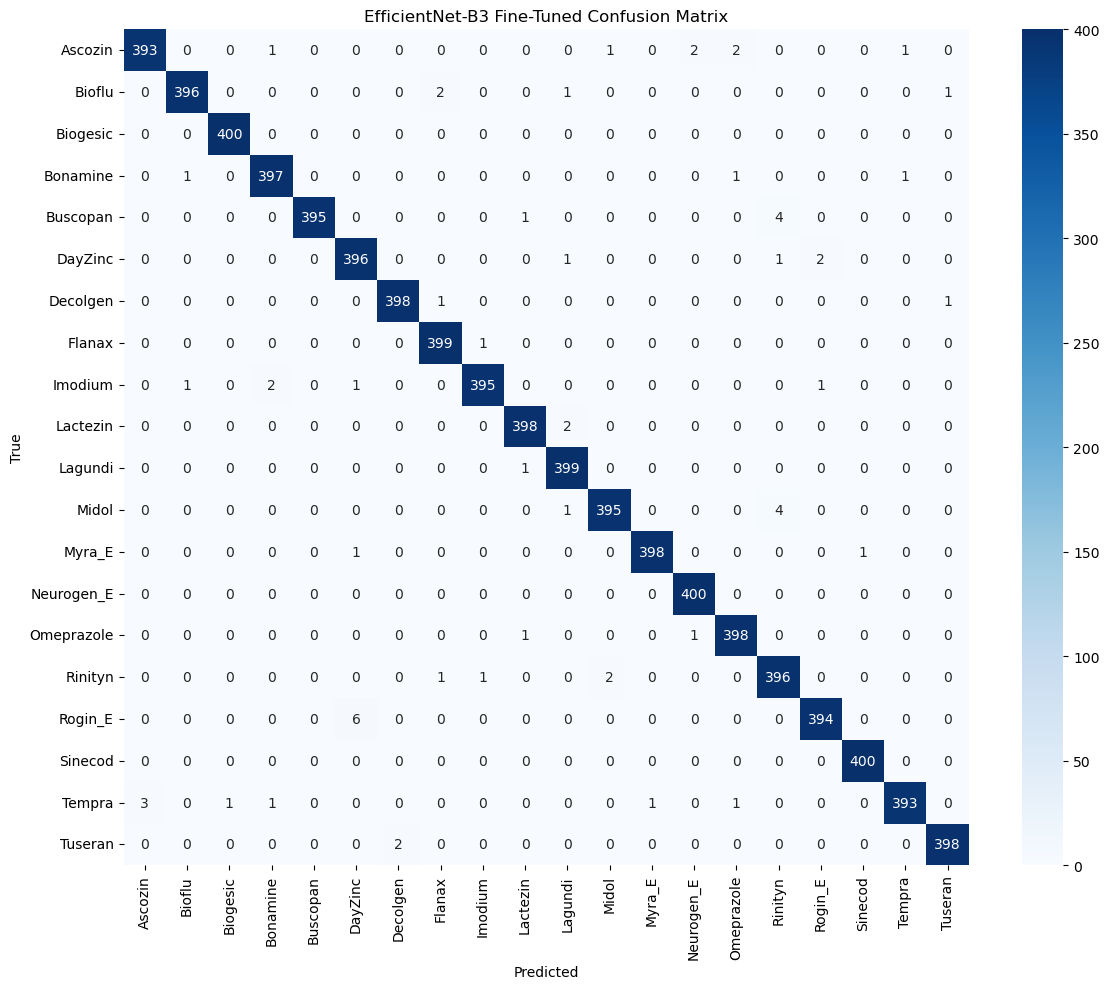


Overall Validation Accuracy: 99.22%

Per-Class Accuracy:
Ascozin: 98.25%
Bioflu: 99.00%
Biogesic: 100.00%
Bonamine: 99.25%
Buscopan: 98.75%
DayZinc: 99.00%
Decolgen: 99.50%
Flanax: 99.75%
Imodium: 98.75%
Lactezin: 99.50%
Lagundi: 99.75%
Midol: 98.75%
Myra_E: 99.50%
Neurogen_E: 100.00%
Omeprazole: 99.50%
Rinityn: 99.00%
Rogin_E: 98.50%
Sinecod: 100.00%
Tempra: 98.25%
Tuseran: 99.50%

Class-wise Precision/Recall:
Ascozin: Precision=0.992, Recall=0.983
Bioflu: Precision=0.995, Recall=0.990
Biogesic: Precision=0.998, Recall=1.000
Bonamine: Precision=0.990, Recall=0.993
Buscopan: Precision=1.000, Recall=0.988
DayZinc: Precision=0.980, Recall=0.990
Decolgen: Precision=0.995, Recall=0.995
Flanax: Precision=0.990, Recall=0.998
Imodium: Precision=0.995, Recall=0.988
Lactezin: Precision=0.993, Recall=0.995
Lagundi: Precision=0.988, Recall=0.998
Midol: Precision=0.992, Recall=0.988
Myra_E: Precision=0.997, Recall=0.995
Neurogen_E: Precision=0.993, Recall=1.000
Omeprazole: Precision=0.990, Recall

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# 1. Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dir = "F:/Class/FYP/newdataset/validation"  # Update your path
batch_size = 32

# 2. Define Model Class (match fine-tuned training configuration)
class EfficientNetTransferLearning(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = models.efficientnet_b3(weights="IMAGENET1K_V1")
        
        # Replace classifier layer
        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# 3. Define Dataset Class (match fine-tuned training configuration)
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.transform = transforms.Compose([
            transforms.Resize((300, 300)),  # Model input size for EfficientNet-B3
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(image), torch.tensor(self.labels[idx])

# 4. Load Saved Fine-Tuned Model
checkpoint = torch.load("efficientnet_b3_finetuned.pth")  # Load the fine-tuned model checkpoint
model = EfficientNetTransferLearning(num_classes=len(checkpoint['class_names'])).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 5. Prepare Validation Data
val_dataset = ImageDataset(val_dir)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

# 6. Run Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 7. Generate Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, 
                           target_names=checkpoint['class_names'], 
                           digits=4))

# 8. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=checkpoint['class_names'],
            yticklabels=checkpoint['class_names'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNet-B3 Fine-Tuned Confusion Matrix')
plt.tight_layout()
plt.savefig('efficientnet_b3_finetuned_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. Additional Metrics
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\nOverall Validation Accuracy: {accuracy*100:.2f}%")

# Per-class accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(checkpoint['class_names']):
    print(f"{class_name}: {class_acc[i]*100:.2f}%")

# Precision-Recall for each class
print("\nClass-wise Precision/Recall:")
for i, class_name in enumerate(checkpoint['class_names']):
    precision = cm[i,i] / cm[:,i].sum()
    recall = cm[i,i] / cm[i,:].sum()
    print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}")
